# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import webbrowser as wb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from collections import Counter
from scipy import stats
import pickle

C:\Users\Sybiru_System_REBORN\AppData\Local\Temp\ipykernel_11136\2063806418.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Leitura do CSV

In [3]:
indicium = pd.read_csv("teste_indicium_precificacao.csv")
indicium['nome'] = indicium['nome'].fillna('') #arrumando possiveis erros que possam ocorrer ao analisar imoveis com nome vazio

# Funções

In [4]:
#Para encontrar as 10 palavras mais frequentes em um determinado dataframe
def top10_frequent_words(df):    
    all_names = ' '.join(df['nome'])    
    word_counts = Counter(all_names.split())    
    top_words = word_counts.most_common(10)
    return [word for word, _ in top_words]

#Remove o quartil maior e menor seguindo a distribuição de poisson
def remove_poisson_outliers(df, column): 
    # Calcula os quartis
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    # Calcula o intervalo interquartil (IQR)
    iqr = q3 - q1
    # Define os limites inferior e superior para outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Filtra os valores dentro do intervalo
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_cleaned

# Função para dizer qual o preço previsto com base no modelo acima. 
# Considera as variáveis 'bairro_group', 'room_type', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'disponibilidade_365' para esse cálculo.
def predict_price(input_json):      
    input_df = pd.DataFrame([input_json])    
    required_features = ['bairro', 'room_type', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'disponibilidade_365']
    input_df = df_cleaned[required_features]    
    predicted_price = model_simple.predict(input_df)[0]    
    return int(round(predicted_price))

# 1. Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e apresentando algumas hipóteses de negócio relacionadas. Seja criativo!

# === Análises === 

Abaixo estão algumas das análises feitas para entender melhor os dados e usa-las no modelo de precificação. Outros relatórios estão presentes nos demais exercícios. 

As análises seguem o mesmo padrão de estrutura: As primeiras linhas servem para filtrar, agrupar e ordenar os dados que serão utilizados nas análises.
Depois esses relatórios gerados são adicionados em um HTML que será aberto em uma nova aba com botões para navegar entre esses relatórios. E por ultimo são gerados os gráficos mostrando os dados mais relevantes encontrados.

# Relatório com a relação entre imóveis com menor disponibilidade(mais alugados) e preço

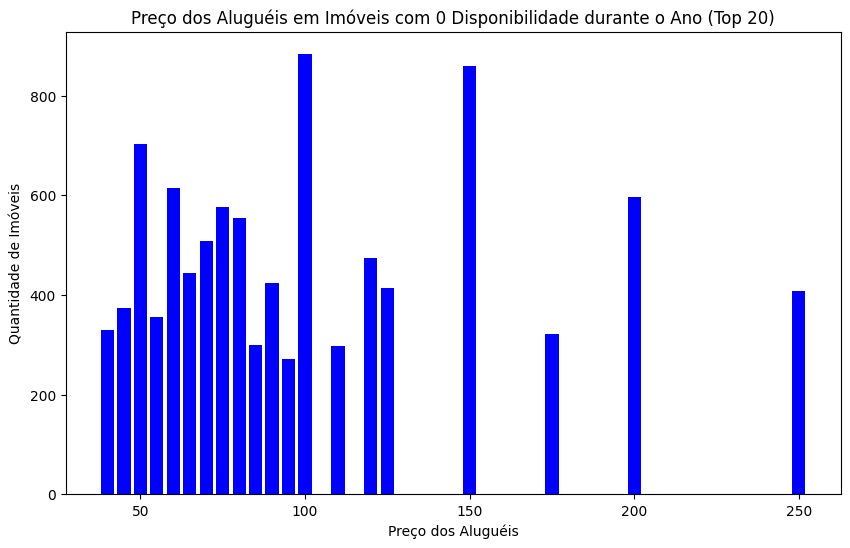

In [5]:
filtered_houses = indicium[(indicium['disponibilidade_365'] == 0)]
frequencia_preco_disponibilidade = filtered_houses.groupby('price').size()
df_frequencia_preco_disponibilidade = pd.DataFrame({'Quantidade de imóveis': frequencia_preco_disponibilidade})
df_frequencia_preco_disponibilidade = df_frequencia_preco_disponibilidade.sort_values(by=['Quantidade de imóveis', 'price'], ascending=[False, False])

html_table = df_frequencia_preco_disponibilidade.to_html()
html_table_with_title = f"<h2>Preço dos alugueis em imóveis com 0 disponibilidade durante o ano</h2>\n{html_table}"
with open("relatorio_preco_disponibilidade_0.html", "w") as file:
    file.write(html_table_with_title)
with open("relatorio_preco_disponibilidade_0.html", "r") as file:
    relatorio_preco_disponibilidade_0 = file.read()    

plt.figure(figsize=(10, 6))
plt.bar(df_frequencia_preco_disponibilidade.index[:20], df_frequencia_preco_disponibilidade['Quantidade de imóveis'][:20], color='blue', width=4)
plt.xlabel('Preço dos Aluguéis')
plt.ylabel('Quantidade de Imóveis')
plt.title('Preço dos Aluguéis em Imóveis com 0 Disponibilidade durante o Ano (Top 20)')
plt.show()

# Relatório com a relação entre número de reviews e preço

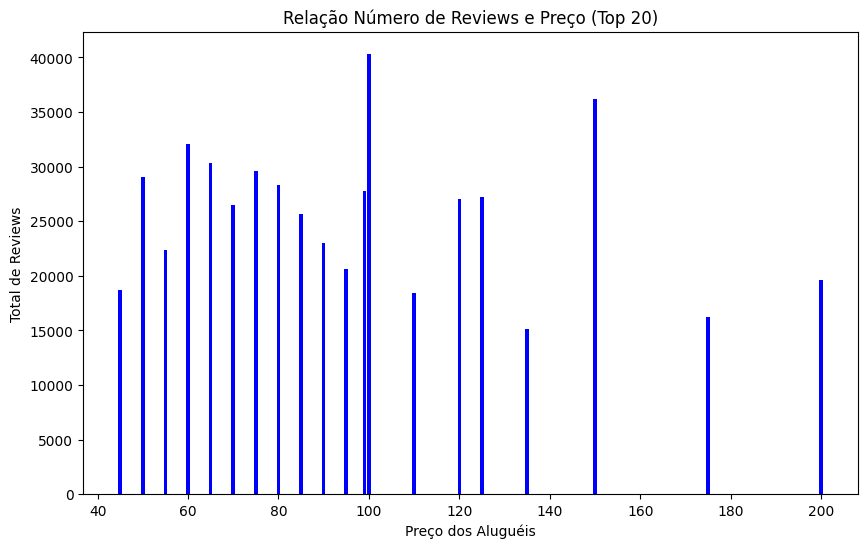

In [6]:
df_frequencia_reviews = indicium.groupby('price')['numero_de_reviews'].sum().reset_index()
df_frequencia_reviews.columns = ['Preço', 'Total de Reviews']
df_frequencia_reviews = df_frequencia_reviews.sort_values(by=['Total de Reviews', 'Preço'], ascending=[False, False])
df_frequencia_reviews = df_frequencia_reviews[['Preço', 'Total de Reviews']]

html_table = df_frequencia_reviews.to_html(index=False)
html_table_with_title = f"<h2>Relação número de reviews e preço, ordenado pelos reviews</h2>\n{html_table}"
with open("relatorio_preco_reviews.html", "w") as file:    
    file.write(html_table_with_title)
with open("relatorio_preco_reviews.html", "r") as file:    
    relatorio_preco_reviews = file.read()

plt.figure(figsize=(10, 6))
plt.bar(df_frequencia_reviews['Preço'][:20], df_frequencia_reviews['Total de Reviews'][:20], color='blue')
plt.xlabel('Preço dos Aluguéis')
plt.ylabel('Total de Reviews')
plt.title('Relação Número de Reviews e Preço (Top 20)')
plt.show()

# Relatório com a relação entre nome e preço do aluguel

C:\Users\Sybiru_System_REBORN\AppData\Local\Temp\ipykernel_11136\1076533837.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


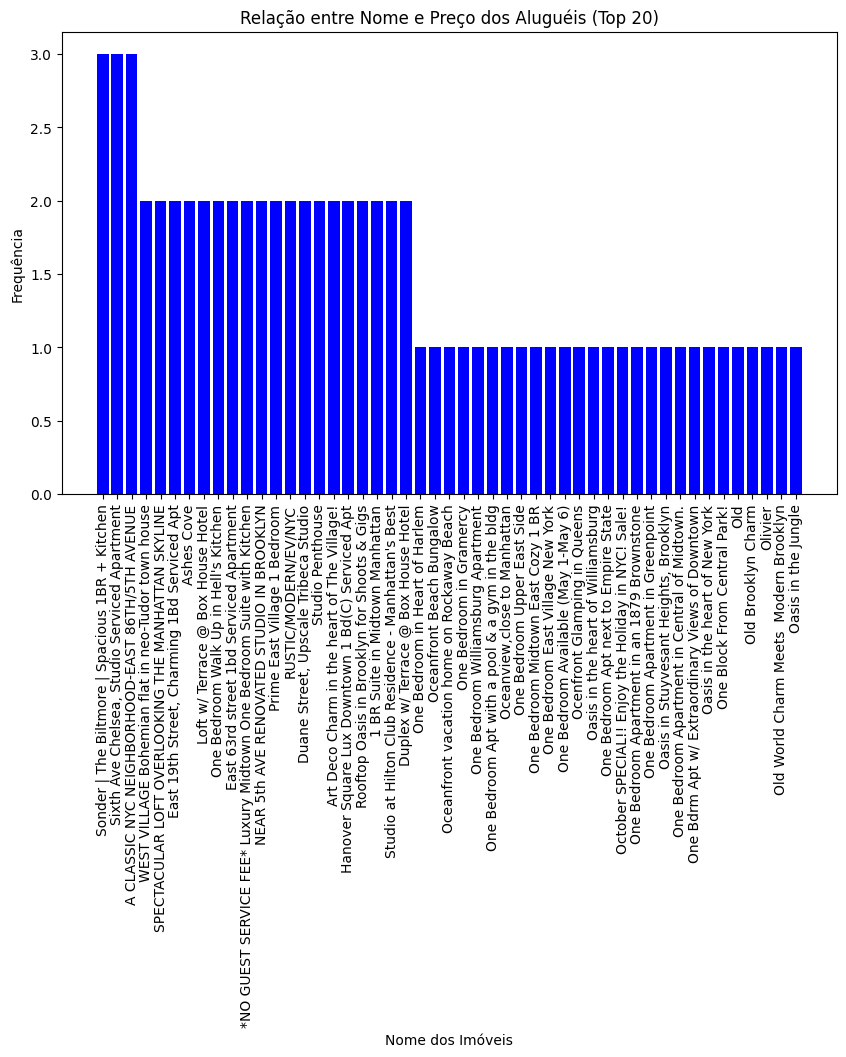

In [7]:
filtered_houses = indicium[(indicium['price'] >= 200)]
df_nome_preco_frequencia = filtered_houses.groupby(['nome', 'price']).size().reset_index(name='Frequência')
df_nome_preco_frequencia.columns = ['Nome', 'Preço', 'Frequência']
df_nome_preco_frequencia = df_nome_preco_frequencia.sort_values(by='Frequência', ascending=False)

html_table = df_nome_preco_frequencia.to_html(index=False)
html_table_with_title = f"<h2>Relação entre nome e preço dos aluguéis</h2>\n{html_table}"
with open("relatorio_nome_preco_frequencia.html", "w",encoding="utf-8", errors="ignore") as file:   
    file.write(html_table_with_title)
with open("relatorio_nome_preco_frequencia.html", "r",encoding="utf-8", errors="ignore") as file:   
    relatorio_nome_preco_frequencia = file.read()
    
plt.figure(figsize=(10, 6))
plt.bar(df_nome_preco_frequencia['Nome'][:50], df_nome_preco_frequencia['Frequência'][:50], color='blue')
plt.xlabel('Nome dos Imóveis')
plt.ylabel('Frequência')
plt.title('Relação entre Nome e Preço dos Aluguéis (Top 20)')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

# Relatório com a relação entre nome e ordenando pelo preço do aluguel

In [8]:
filtered_houses = indicium[(indicium['price'] >= 2000)]
df_nome_preco = filtered_houses.groupby(['nome'])['price'].apply(list).reset_index()
df_nome_preco.columns = ['Nome', 'Preço']
df_nome_preco = df_nome_preco.sort_values(by='Preço', ascending=False)
df_nome_preco['Preço'] = df_nome_preco['Preço'].apply(lambda x: ', '.join(map(str, x)))

html_table = df_nome_preco.to_html(index=False)
html_table_with_title = f"<h2>Relação entre nome e preço dos aluguéis</h2>\n{html_table}"
with open("relatorio_nome_preco.html", "w",encoding="utf-8", errors="ignore") as file:   
    file.write(html_table_with_title)
with open("relatorio_nome_preco.html", "r", encoding="utf-8") as file:
    relatorio_nome_preco = file.read()    


# Relatório com a relação entre nome e strings especificas, oredenando pelo preço do aluguel

In [9]:
luxury_houses = indicium[indicium['nome'].str.contains('luxury', case=False)]
df_nome_preco = luxury_houses.groupby(['nome'])['price'].apply(list).reset_index()
df_nome_preco.columns = ['Nome', 'Preço']
df_nome_preco = df_nome_preco.sort_values(by='Preço', ascending=False)
df_nome_preco['Preço'] = df_nome_preco['Preço'].apply(lambda x: ', '.join(map(str, x)))

html_table = df_nome_preco.to_html(index=False)
html_table_with_title = f"<h2>Relação entre nomes que contenham a palavra 'luxury' e preço dos aluguéis</h2>\n{html_table}"
with open("relatorio_nome_preco_luxury.html", "w", encoding="utf-8") as file:
    file.write(html_table_with_title)
with open("relatorio_nome_preco_luxury.html", "r", encoding="utf-8") as file:
    relatorio_nome_preco_luxury = file.read()

# 2. Responda também às seguintes perguntas:


# a. Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

Primeiramente foi analisado como se comporta um gráfico relacionando a frequência de preço, agrupando por espaços de 50 em 50 conforme gráfico a seguir:

# Relátório frequência de aluguéis por intervalo

C:\Users\Sybiru_System_REBORN\AppData\Local\Temp\ipykernel_11136\3666932816.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_frequencia_aluguel_groupby = df_frequencia_aluguel.groupby('Categoria').size().reset_index(name='Frequência')


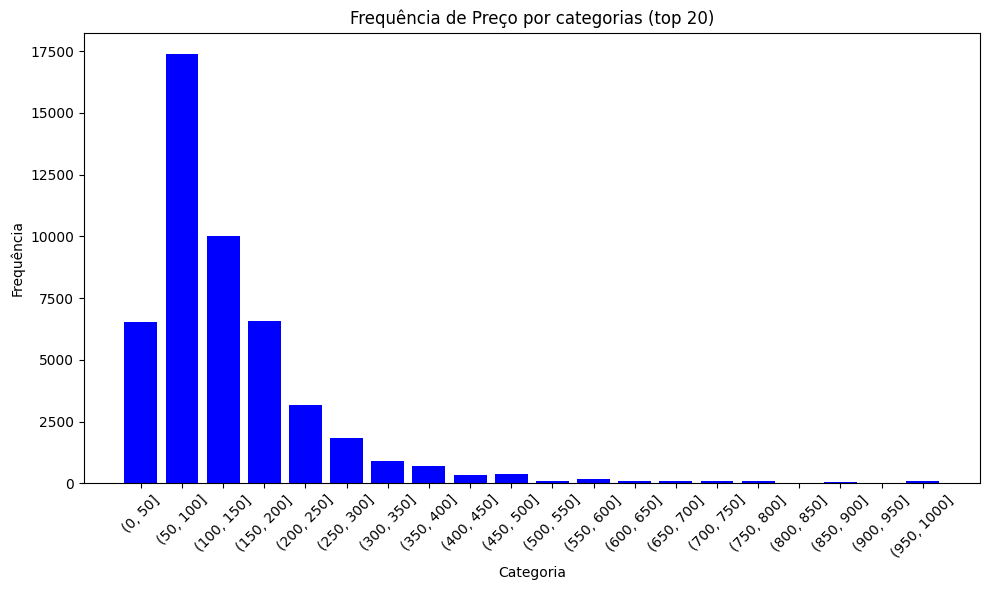

In [10]:
bins = range(0, 10001, 50)  # Intervalos de 100 de 0 a 10000
df_frequencia_aluguel = pd.DataFrame({'Categoria': pd.cut(indicium['price'], bins=bins)})
df_frequencia_aluguel_groupby = df_frequencia_aluguel.groupby('Categoria').size().reset_index(name='Frequência')
df_frequencia_aluguel_groupby = df_frequencia_aluguel_groupby.sort_values(by='Categoria')

html_table = df_frequencia_aluguel_groupby.to_html(index=False)
html_table_with_title = f"<h2>Frequencia de preço</h2>\n{html_table}"
with open("relatorio_frequencia_aluguel.html", "w") as file:    
    file.write(html_table_with_title)
with open("relatorio_frequencia_aluguel.html", "r") as file:    
    relatorio_frequencia_aluguel = file.read()

plt.figure(figsize=(10, 6))
plt.bar(df_frequencia_aluguel_groupby['Categoria'][:20].astype(str), df_frequencia_aluguel_groupby['Frequência'][:20], color='blue')
plt.xlabel('Categoria')
plt.ylabel('Frequência')
plt.title('Frequência de Preço por categorias (top 20)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Dessa forma, notou-se que é uma curva semelhante a distribuição de poisson. Sendo assim, usando da função 'remove_poisson_outliers' foi removido o quartil maior e o quartil menor, ou seja, ou valores muito distantes da média do gráfico como alugueis de 10000 ou de 0 e que, por tanto, não apresentam relevância estatistica. Um novo relatório foi gerado:

# Relatório frequência de aluguéis, depois de remover outliers

C:\Users\Sybiru_System_REBORN\AppData\Local\Temp\ipykernel_11136\2143352423.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_frequencia_aluguel_groupby = df_frequencia_aluguel.groupby('Categoria').size().reset_index(name='Frequência')


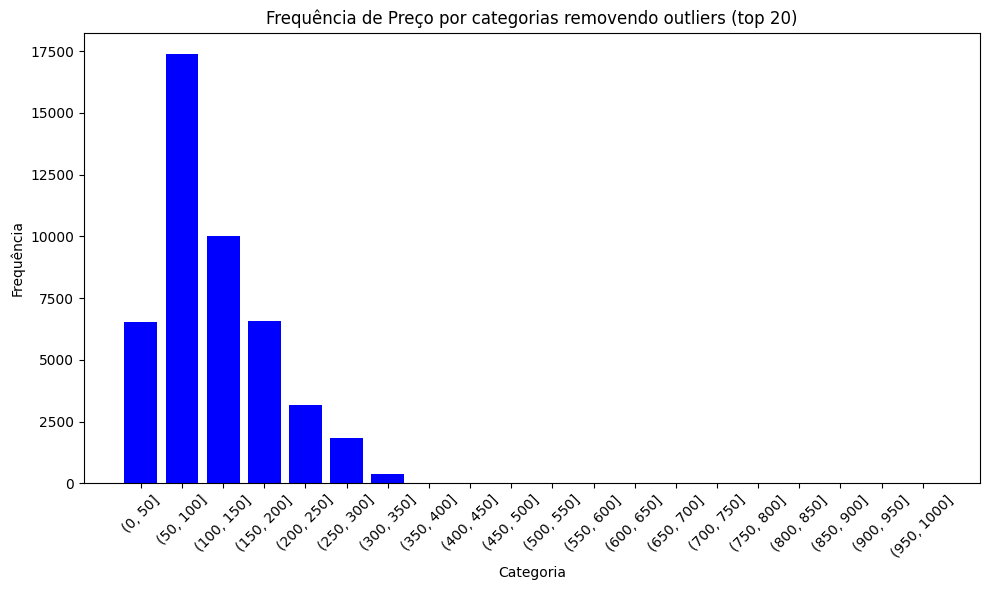

In [11]:
bins = range(0, 10001, 50)  # Intervalos de 100 de 0 a 10000
df_cleaned = remove_poisson_outliers(indicium, 'price')
df_frequencia_aluguel = pd.DataFrame({'Categoria': pd.cut(df_cleaned['price'], bins=bins)})
df_frequencia_aluguel_groupby = df_frequencia_aluguel.groupby('Categoria').size().reset_index(name='Frequência')
df_frequencia_aluguel_groupby = df_frequencia_aluguel_groupby.sort_values(by='Categoria')

html_table = df_frequencia_aluguel_groupby.to_html(index=False)
html_table_with_title = f"<h2>Frequencia de preço depois de remover quartil maior</h2>\n{html_table}"
with open("relatorio_frequencia_aluguel_outliers.html", "w") as file:    
    file.write(html_table_with_title)
with open("relatorio_frequencia_aluguel_outliers.html", "r") as file:    
    relatorio_frequencia_aluguel_outliers = file.read()

plt.figure(figsize=(10, 6))
plt.bar(df_frequencia_aluguel_groupby['Categoria'][:20].astype(str), df_frequencia_aluguel_groupby['Frequência'][:20], color='blue')
plt.xlabel('Categoria')
plt.ylabel('Frequência')
plt.title('Frequência de Preço por categorias removendo outliers (top 20)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Após a remoção dos outliers na tabela de preço, foi feita uma análise da frequência de imóveis por bairro, para ver se era necessário também a remoção de possíveis outliers conforme o gráfico a seguir:

# Relação da quantidade de imóveis por bairro

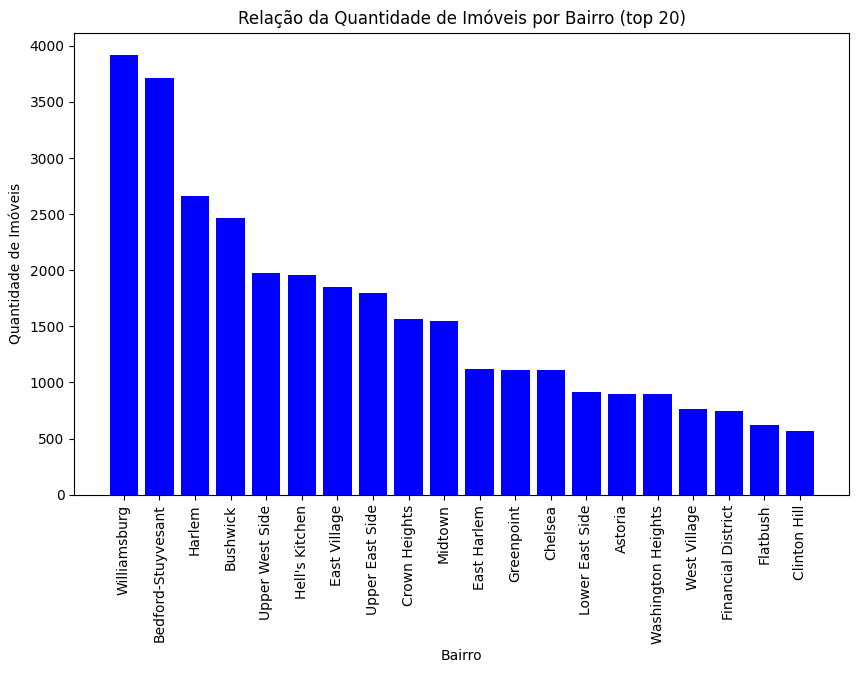

In [12]:
frequencia_preco_bairro = indicium.groupby('bairro').size()
df_frequencia_preco_bairro = pd.DataFrame({'Quantidade de Imóveis': frequencia_preco_bairro})
df_frequencia_preco_bairro = df_frequencia_preco_bairro.sort_values(by='Quantidade de Imóveis', ascending=False)

html_table = df_frequencia_preco_bairro.to_html()
html_table_with_title = f"<h2>Relação da quantidade de imóveis por bairro</h2>\n{html_table}"
with open("relatorio_preco_bairro.html", "w") as file:    
    file.write(html_table_with_title)
with open("relatorio_preco_bairro.html", "r") as file:    
    relatorio_preco_bairro = file.read()    

plt.figure(figsize=(10, 6))
plt.bar(df_frequencia_preco_bairro.index[:20], df_frequencia_preco_bairro['Quantidade de Imóveis'][:20], color='blue')
plt.xlabel('Bairro')
plt.ylabel('Quantidade de Imóveis')
plt.title('Relação da Quantidade de Imóveis por Bairro (top 20)')
plt.xticks(rotation=90)
plt.show()

Com essa análise viu-se necessário a remoção dos outliers já que vários bairros apresentavam pouco domicílios (1,2) em relação ao bairro com maior quantidade Williamsburg	com 3920 domicilios. Dessa forma, foram removidos os bairros com menos de 40 domicilios (irrelevantes estatisticamente) o que gerou o gráfico a seguir:

# Relação da quantidade de imóveis por bairro removendo os outliers

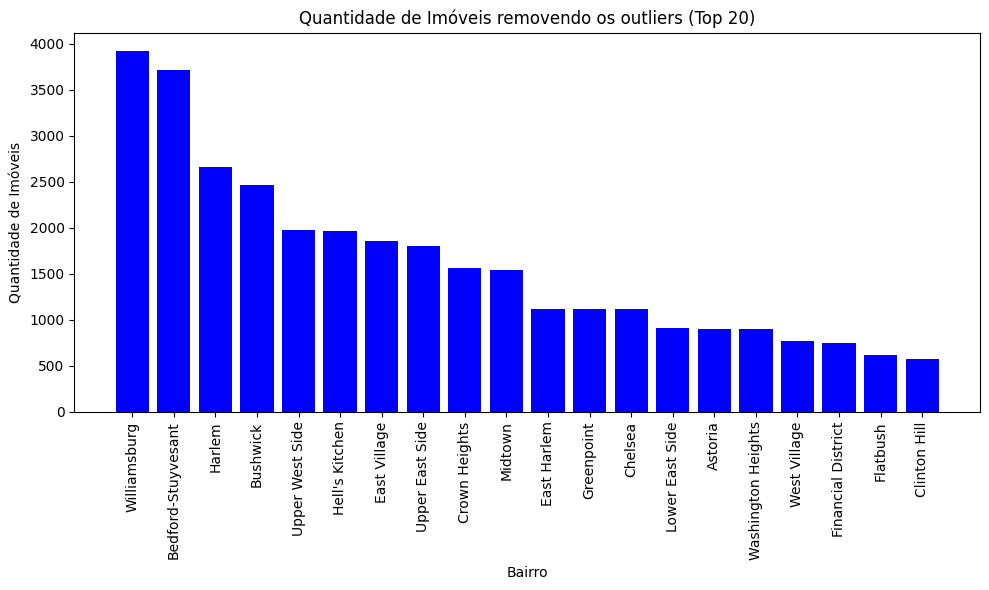

In [13]:
frequencia_preco_bairro = indicium.groupby('bairro').size().reset_index(name='Quantidade de Imóveis')
df_frequencia_preco_bairro = frequencia_preco_bairro.sort_values(by='Quantidade de Imóveis', ascending=False)
freq_cleaned = df_frequencia_preco_bairro[df_frequencia_preco_bairro['Quantidade de Imóveis'] > 50];
html_table = df_frequencia_preco_bairro.to_html()
html_table_with_title = f"<h2>Quantidade de Imóveis removendo os outliers</h2>\n{html_table}"
with open("relatorio_frequencia_preco_bairro.html", "w") as file:    
    file.write(html_table_with_title)
with open("relatorio_frequencia_preco_bairro.html", "r") as file:    
    relatorio_frequencia_preco_bairro = file.read()

bairros = freq_cleaned['bairro']
quantidade_imoveis = freq_cleaned['Quantidade de Imóveis']
plt.figure(figsize=(10, 6))
plt.bar(bairros[:20], quantidade_imoveis[:20], color='blue')
plt.xlabel('Bairro')
plt.ylabel('Quantidade de Imóveis')
plt.title('Quantidade de Imóveis removendo os outliers (Top 20)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Por fim, juntou-se as duas análises para decidir qual seria o melhor bairro para investir de acordo com o rendimento médio por bairro. A análise final chegou a conclusão de que "West village" é o bairro mais rentável e, portanto, melhor opção de investimento conforme o gráfico a seguir:

# Relatório com a relação de rendimentos médios por bairro, depois de remover outliers e ordenado por maior rendimento

C:\Users\Sybiru_System_REBORN\AppData\Local\Temp\ipykernel_11136\1279254106.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['rendimento'] = df_cleaned['price'] * (365 - df_cleaned['disponibilidade_365'])


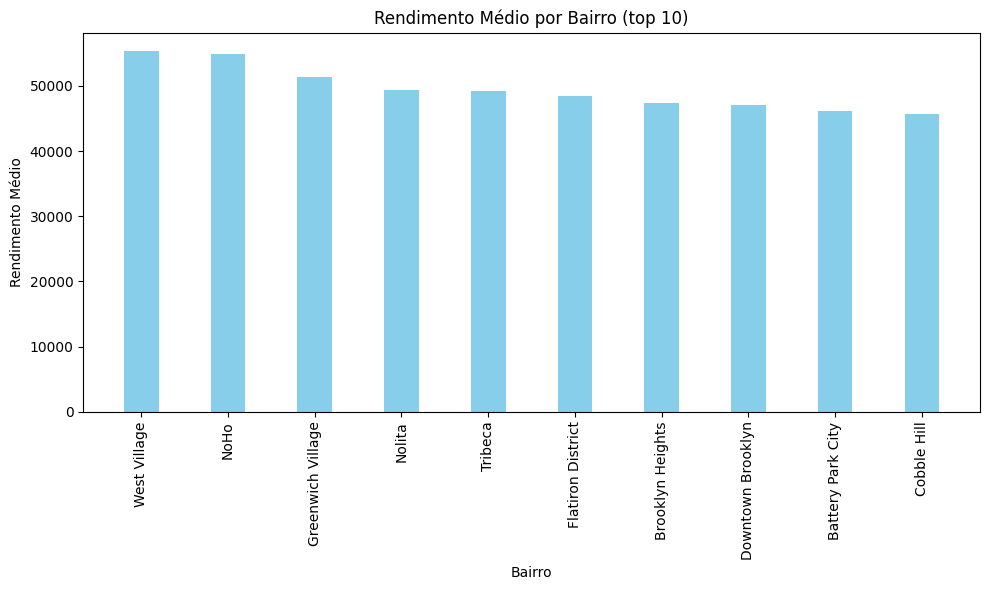

In [14]:
df_filtrado = indicium[indicium['bairro'].isin(freq_cleaned['bairro'])]
df_cleaned = remove_poisson_outliers(df_filtrado, 'price')
df_cleaned['rendimento'] = df_cleaned['price'] * (365 - df_cleaned['disponibilidade_365'])
df_cleaned.loc[df_cleaned['disponibilidade_365'] == 365, 'rendimento'] = 0
df_bairro_rendimento = df_cleaned.groupby('bairro')['rendimento'].mean().reset_index().round(2)
df_bairro_rendimento = df_bairro_rendimento.sort_values(by='rendimento', ascending=False)
df_final = df_bairro_rendimento[['bairro', 'rendimento']]

html_table = df_final.to_html(index=False)
html_table_with_title = f"<h2> relação de rendimentos médios por bairro</h2>\n{html_table}"
with open("relatorio_bairro_rendimento.html", "w",encoding="utf-8", errors="ignore") as file:   
    file.write(html_table_with_title)    
with open("relatorio_bairro_rendimento.html", "r", encoding="utf-8") as file:
   relatorio_bairro_rendimento = file.read() 

x = df_final['bairro'][:10]
y = df_final['rendimento'][:10]

# Cria o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(x, y, color='skyblue', width=0.4)
plt.xlabel('Bairro')
plt.ylabel('Rendimento Médio')
plt.title('Rendimento Médio por Bairro (top 10)')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()    

# b. O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

Segundo as análises abaixo, o número minímo de noites e a disponibilidade ao longo do ano não indicam um padrão visivel no preço.

# Relação entre mínimo de noites e preço

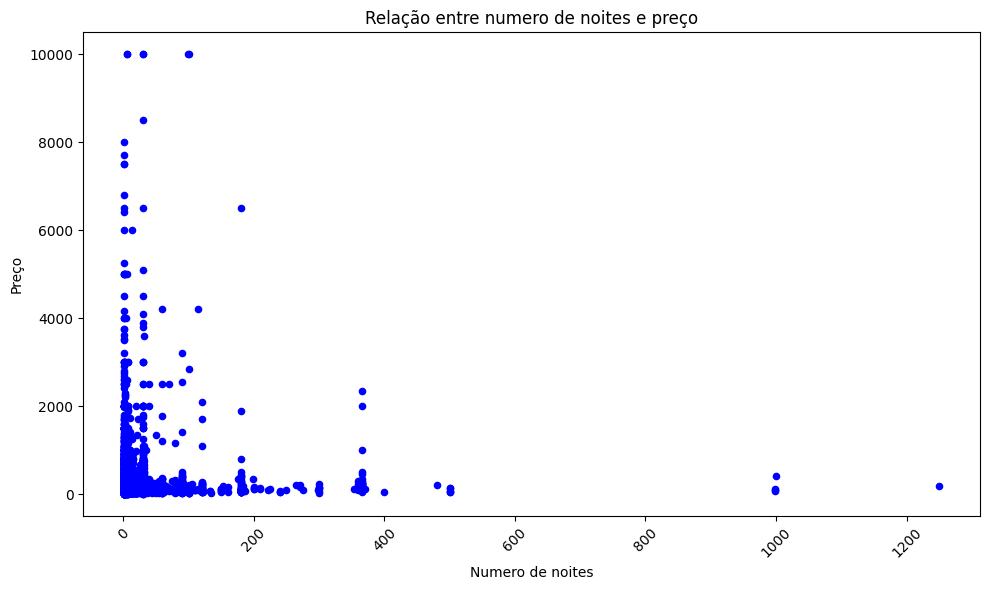

In [15]:
df_minimo_noites_preco = indicium.sort_values(by='minimo_noites', ascending=False)

html_table = df_minimo_noites_preco.to_html()
html_table_with_title = f"<h2>Relação do mínimo de noites e preço</h2>\n{html_table}"
with open("relatorio_minimo_noites_preco.html", "w", encoding="utf-8", errors="ignore") as file:    
    file.write(html_table_with_title)
with open("relatorio_minimo_noites_preco.html", "r", encoding="utf-8", errors="ignore") as file:    
    relatorio_minimo_noites_preco = file.read();    

plt.figure(figsize=(10, 6))
plt.scatter(df_minimo_noites_preco['minimo_noites'], df_minimo_noites_preco['price'], color='blue', s=20) 
plt.xlabel('Numero de noites')
plt.ylabel('Preço')
plt.title('Relação entre numero de noites e preço')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

# Relatório com a relação entre disponibilidade e preço

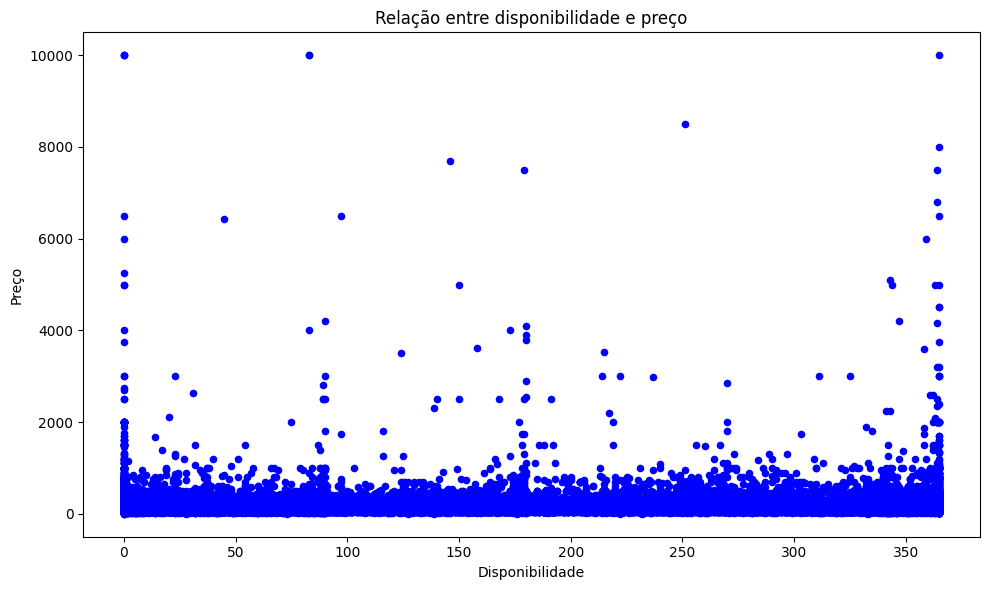

In [16]:
df_disponibilidade_preco = indicium.sort_values(by='disponibilidade_365')

html_table = df_disponibilidade_preco.to_html()
html_table_with_title = f"<h2>Relação do mínimo de noites e preço</h2>\n{html_table}"
with open("relatorio_disponibilidade_preco.html", "w", encoding="utf-8", errors="ignore") as file:    
    file.write(html_table_with_title)
with open("relatorio_disponibilidade_preco.html", "r", encoding="utf-8", errors="ignore") as file:    
    relatorio_disponibilidade_preco = file.read()    

plt.figure(figsize=(10, 6))
plt.scatter(df_disponibilidade_preco['disponibilidade_365'], df_disponibilidade_preco['price'], color='blue', s=20) 
plt.xlabel('Disponibilidade')
plt.ylabel('Preço')
plt.title('Relação entre disponibilidade e preço') 
plt.tight_layout()
plt.show()

# c. Existe algum padrão no texto do nome do local para lugares de mais alto valor?

Usando a função '' para identificar as 10 palavras mais frequentes em um dataframe e filtrando o csv para mostrar apenas imóveis com preço de aluguél maior que $2000 foram encontradas as seguintes palavras/strings: 'in', 'by', 'Luxury', '2', '-', 'Park', 'Beautiful', 'Bedroom', 'for', 'Townhouse'; conforme o código abaixo (anexo 01). Selecionando apenas as palavras úteis para a busca temos: 'Luxury' e 'Beautiful'. 

Agora, analisando os nomes de lugares com mais alto valor (domicilios com aluguel acima ou igual a $2000) temos 110 (anexo 02) onde 14 possuem a palavra 'luxury' (anexo 03) e 8 possuem a palavra 'beautiful' (anexo 04). Apesar de possuir alguma relevância estatistica (12% e 7% respectivamente) existem 1704 domicilíos com aluguel abaixo de $2000 com a palavra 'luxury' (anexo 05) e 2541 domicilíos com aluguel abaixo de $2000 com a palavra 'beautiful' (anexo 06), o que torna inviável agrupar domicilios por palavras em comum buscando um preço parecido.

In [17]:
# (anexo 01) 
filtered_houses = indicium[(indicium['price'] >= 2000)]
print(top10_frequent_words(filtered_houses))

['in', 'by', 'Luxury', '2', '-', 'Park', 'Beautiful', 'Bedroom', 'for', 'Townhouse']


In [18]:
# (anexo 02) 
count_houses_2000 = indicium[indicium['price'] >= 2000].shape[0]
print(count_houses_2000)

110


In [19]:
# (anexo 03)
count_houses_2000_luxury = indicium[(indicium['price'] >= 2000) & (indicium['nome'].str.contains('luxury', case=False))].shape[0]
print(count_houses_2000_luxury)

14


In [20]:
# (anexo 04)
count_houses_2000_beautiful = indicium[(indicium['price'] >= 2000) & (indicium['nome'].str.contains('Beautiful', case=False))].shape[0]
print(count_houses_2000_beautiful)

8


In [21]:
# (anexo 05)
count_houses_luxury = indicium[(indicium['price'] < 2000) & (indicium['nome'].str.contains('luxury', case=False))].shape[0]
print(count_houses_luxury)

1704


In [22]:
# (anexo 06)
count_houses_beautiful = indicium[(indicium['price'] < 2000) & (indicium['nome'].str.contains('Beautiful', case=False))].shape[0]
print(count_houses_beautiful)

2541


# 3. Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?


As variáveis utilizadas foram: 'bairro', 'room_type', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'disponibilidade_365' visto que elas possuem alguma relação com o preço. O uso de 'bairro' ao invez de 'bairro_group' foi devido a ser menos genérico, melhorando a estabilidade do modelo. Não foram aplicadas transformações a essas variáveis. 

O tipo de problema que estamos resolvendo é o de regressão pois todos os dados possuem a mesma classificação: são todos endereços válidos de imóveis em Nova York. 

O modelo que melhor aproximou os dados foi o de Regressão Linear pois, apesar de ser mais simples que outros modelos como o Random forest, ele apresentou resultados mais coesos para essa aplicação dado o tempo de resolução do desafio. As vantagens do modelo de Regressão Linear são a simplicidade e eficiência computacional, deixando o modelo mais leve. Por outro lado, esse modelo é muito sensivel a outliers ( o que foi melhorado ao filtrar os elementos como será mostrado abaixo).

O modelo utiliza três medidas de performance: MSE, MAE e R² (explicadas melhor nos comentários do modelo abaixo) . A escolha dessas métricas permite uma melhor avaliação do modelo, cobrindo tanto a magnitude dos erros de previsão (MSE e MAE) quanto a eficácia geral do modelo em explicar as variações observadas nos dados (R²).

# Modelo de Regressão Linear

MSE: 1958.6797914575682
MAE: 31.96817261938687
R^2: 0.5395850649655561


C:\Users\Sybiru_System_REBORN\AppData\Local\Temp\ipykernel_11136\3627912155.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')


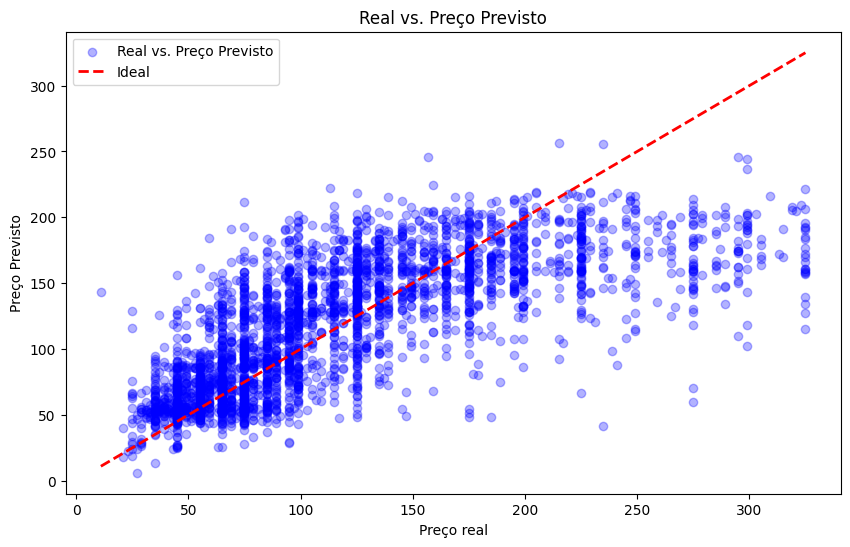

In [24]:
# Primeiro filtra o dataframe por endereços que não possuam um valor nulo de reviews por mês, remove os
# bairros com uma quantidade irrelevante de endereços para a amostra e por ultimo remove os outliers de
# preço que já foram abordados exercício 2a.
df_filtrado = indicium[indicium['bairro'].isin(freq_cleaned['bairro']) & (indicium['reviews_por_mes'].notnull() & indicium['price'] > 0)]
df_cleaned = remove_poisson_outliers(df_filtrado, 'price')

# Define as características categóricas a serem usadas no modelo. Neste caso, 'bairro' é usado para capturar padrões
# mais específicos baseados na localização dos preços, e 'room_type' para diferenciar entre tipos de acomodações
# (por exemplo, casa/apartamento inteiro ou quarto privado).
categorical_features = ['bairro', 'room_type']  
numerical_features = ['minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'disponibilidade_365']

# Seleciona características e a variável alvo do DataFrame. 'X' inclui características que podem influenciar o preço,
# como 'bairro', 'room_type' para o tipo de casa/quarto, 'minimo_noites', 'numero_de_reviews' que aumenta a precisão
# dos dados da coluna disponibilidade_365 já que endereços ocupados o ano todo (disponibilidade_365) com quantidade
# baixa de reviews podem conter informações não precisas, 'reviews_por_mes', e 'disponibilidade_365' # para a 
# disponibilidade ao longo do ano. 'y' é a variável alvo, representando o preço dos imóveis.
X = df_cleaned[['bairro', 'room_type', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'disponibilidade_365']]
y = df_cleaned['price']

# Configura etapas de pré-processamento. O ColumnTransformer permite diferentes pré-processamentos para diferentes tipos de características:
# - 'num': StandardScaler é usado para normalizar características numéricas, garantindo que estejam em uma escala similar.
# - 'cat': OneHotEncoder é usado para características categóricas para convertê-las em um formato que pode ser fornecido
#   ao modelo (já que modelos requerem entrada numérica).
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # No change here
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Updated categorical_features
    ]
)

# Define o pipeline do modelo. Um pipeline envolve as etapas de pré-processamento e modelagem, permitindo que sejam tratadas
# como uma única etapa. Isso simplifica o código e ajuda a prevenir erros como vazamento de dados:
# - 'preprocessor': aplica o pré-processamento definido acima.
# - 'regressor': aplica um modelo de Regressão Linear aos dados pré-processados para prever preços.
model_simple = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Divide o conjunto de dados em um conjunto de treinamento e um conjunto de teste. Isso permite que o modelo seja treinado
# em um subconjunto dos dados e, em seguida, avaliado em um subconjunto separado, fornecendo uma estimativa de seu desempenho
# em dados não vistos.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treina o modelo nos dados de treinamento. Isso envolve encontrar os melhores parâmetros para o modelo de Regressão Linear
# com base nas características de entrada (X_train) e na variável alvo (y_train).
model_simple.fit(X_train, y_train)

# Usa o modelo treinado para fazer previsões no conjunto de teste. Isso gera preços previstos (y_pred) para cada anúncio
# no conjunto de teste, permitindo avaliar quão bem o modelo aprendeu a prever preços.
y_pred = model_simple.predict(X_test)  # Ensure you're using 'model_simple' here

# Avalia o desempenho do modelo usando métricas comuns para modelos de regressão:
# - MSE (Erro Quadrático Médio): Mede a diferença quadrada média entre preços reais e previstos.
# - MAE (Erro Absoluto Médio): Mede a diferença absoluta média entre preços reais e previstos.
# - R^2 (Coeficiente de Determinação): Indica a proporção da variância na variável dependente que é previsível a partir das variáveis independentes.
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'R^2: {r2_score(y_test, y_pred)}')

with open('modelo_predicao_preco.pkl', 'wb') as arquivo_saida:
    pickle.dump(model_simple, arquivo_saida)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='blue', label='Real vs. Preço Previsto')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')
plt.xlabel('Preço real')
plt.ylabel('Preço Previsto')
plt.title('Real vs. Preço Previsto')
plt.legend()
plt.show()

# Explicação do gráfico: a linha tracejada representa o preço que os endereços deveriam ter e os
# circulos azuis mostram o valor real encontrado no dataframe usado. Em um modelo ideal, todas
# os circulos azuis estariam em cima da linha tracejada

# 4. Supondo um apartamento com as seguintes características:

{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'price': 225,
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibili# dade_365': 355}

Qual seria a sua sugestão de preço?


## Usando o modelo de predição acima e com o auxilio de uma nova função que recebe um dado e diz qual deveria ser o preço ideal (código abaixo), a sugestão de preço é de $205 para aumentar os ganhos, reduzindo a quantidade de tempo ocioso como mostra na coluna 'disponibilidade_365'.

In [ ]:

data = {'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'price': 225,
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}

predicted_price = predict_price(data)
print(predicted_price)


# HTML com todos os relatórios gerados

In [ ]:
html_consolidado = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Relatórios</title>
</head>
<body>
    <h1>Relatórios</h1>    
    <button onclick="mostrarRelatorio('relatorio_preco_disponibilidade_0')">Aluguéis com menor disponibilidade(mais alugados) e preço</button>    
    <button onclick="mostrarRelatorio('relatorio_preco_reviews')">Relação entre número de reviews e preço</button>    
    <button onclick="mostrarRelatorio('relatorio_nome_preco_frequencia')">Frequencia de nomes com mesmo preço</button>    
    <button onclick="mostrarRelatorio('relatorio_nome_preco')">Relação entre nome e preço</button>
    <button onclick="mostrarRelatorio('relatorio_nome_preco_luxury')">Endereços com a palavra 'luxury' no nome</button>
    <button onclick="mostrarRelatorio('relatorio_frequencia_aluguel')">Frequencia de preço</button>
    <button onclick="mostrarRelatorio('relatorio_frequencia_aluguel_outliers')">Frequencia de preço removendo outliers</button>
    <button onclick="mostrarRelatorio('relatorio_preco_bairro')">Frequencia de preço por bairro</button>
    <button onclick="mostrarRelatorio('relatorio_preco_bairro_outlier')">Frequencia de preço por bairro removendo outliers</button>
    <button onclick="mostrarRelatorio('relatorio_bairro_rendimento')">Rendimento por bairro</button>
    <button onclick="mostrarRelatorio('relatorio_minimo_noites_preco')">Preço por mínimo de noites</button>
    <button onclick="mostrarRelatorio('relatorio_disponibilidade_preco')">Preço por disponibilidade</button>
    

    <!-- Seção para o relatorio preco_disponibilidade_0 -->
    <div id="relatorio_preco_disponibilidade_0">
        {relatorio_preco_disponibilidade_0}
    </div>

    <!-- Seção para o relatório preco_reviews -->
    <div id="relatorio_preco_reviews">
        {relatorio_preco_reviews}
    </div>    

    <!-- Seção para o relatório nome_preco_frequencia -->
    <div id="relatorio_nome_preco_frequencia">
        {relatorio_nome_preco_frequencia}
    </div>

    <!-- Seção para o relatório nome_preco -->
    <div id="relatorio_nome_preco">
        {relatorio_nome_preco}
    </div>

    <!-- Seção para o relatório nome_preco_luxury -->
    <div id="relatorio_nome_preco_luxury">
        {relatorio_nome_preco_luxury}
    </div>

    <!-- Seção para o relatório frequencia_aluguel -->
    <div id="relatorio_frequencia_aluguel">
        {relatorio_frequencia_aluguel}
    </div>
    
    <!-- Seção para o relatório frequencia_aluguel_outliers -->
    <div id="relatorio_frequencia_aluguel_outliers">
        {relatorio_frequencia_aluguel_outliers}
    </div>   
    
     <!-- Seção para o relatório preco_bairro -->
    <div id="relatorio_preco_bairro">
        {relatorio_preco_bairro}
    </div>  
    
     <!-- Seção para o relatório preco_bairro_outlier -->
    <div id="relatorio_preco_bairro_outlier">
        {relatorio_preco_bairro_outlier}
    </div>
    
    <!-- Seção para o relatorio bairro_rendimento -->
    <div id="relatorio_bairro_rendimento">
        {relatorio_bairro_rendimento}
    </div>
    
    <!-- Seção para o relatorio minimo_noites_preco -->
    <div id="relatorio_minimo_noites_preco">
        {relatorio_minimo_noites_preco}
    </div>

    <!-- Seção para o relatorio disponibilidade_preco-->
    <div id="relatorio_disponibilidade_preco">
        {relatorio_disponibilidade_preco}
    </div>
    
    <script>
        function mostrarRelatorio(relatorioId) {{
            // Esconder todos os relatórios
            const relatorios = document.querySelectorAll('div[id^="relatorio_"]');
            relatorios.forEach(relatorio => {{
                relatorio.style.display = 'none';
            }});

            // Mostrar o relatório selecionado
            const relatorioSelecionado = document.getElementById(relatorioId);
            relatorioSelecionado.style.display = 'block';
        }}
    </script>
</body>
</html>
"""

# Salve o arquivo HTML consolidado
with open("relatorios_consolidados.html", "w", encoding="utf-8", errors="ignore") as file:
    file.write(html_consolidado)